In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import ImageFile

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from pathlib import Path

In [2]:
def load_metadata(metadata_path='fungi-clef-2025/metadata/FungiTastic-FewShot/', image_path='fungi-clef-2025/images/FungiTastic-FewShot/'):
    """Load the metadata for each data split."""
    # Load the metadata for each split
    train_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Train.csv'))
    test_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Val.csv'))

    train_metadata = train_metadata.dropna(subset=["class"])
    train_metadata = train_metadata.groupby('class').filter(lambda x: len(x) > 1)

    train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.2, stratify=train_metadata["class"])
    
    # Label each split
    train_metadata["split"] = "train"
    val_metadata["split"] = "val"
    test_metadata["split"] = "test"

    # Join all of the data together
    df_metadata = pd.concat([train_metadata, val_metadata, test_metadata])

    # Add the full image location for each image
    # Options for image size include 300p, 500p, 720p, fullsize 
    for idx, row in df_metadata.iterrows():
        if row["split"] in ["train", "val"]:
            path = os.path.join(image_path, f"train/300p/{row['filename']}")
        else:
            path = os.path.join(image_path, f"val/300p/{row['filename']}")
        df_metadata.at[idx, "image_path"] = path

    return df_metadata


def mapping(df, label):
    le = LabelEncoder()
    le.fit(df[label])
    df[label + "_label"] = df[label]
    df[label + "_idx"] = le.transform(df[label])

    return df


def apply_random_augmentation(X):
    random_number = random.randint(1, 4)

    if random_number == 1:
        return tf.image.flip_left_right(X)
    if random_number == 2:
        return tf.image.flip_up_down(X)
    if random_number == 3:
        return tf.image.adjust_brightness(X, delta=0.3)
    if random_number == 4:
        return tf.image.adjust_contrast(X, contrast_factor=3)


def preprocess_image_tf(image, target_size):
    # Load image using designated filepath
    img = load_img(image)

    # Get original dimensions
    original_height = tf.cast(tf.shape(img)[0], tf.float32)
    original_width = tf.cast(tf.shape(img)[1], tf.float32)
    
    # Calculate scaling factor to maintain aspect ratio
    height_scale = target_size / original_height
    width_scale = target_size / original_width
    scale = tf.minimum(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = tf.cast(tf.math.round(original_height * scale), tf.int32)
    new_width = tf.cast(tf.math.round(original_width * scale), tf.int32)
    
    # Resize the image while maintaining aspect ratio
    resized_img = tf.image.resize(img, [new_height, new_width], method='bilinear')
    
    # Use resize_with_pad to add padding to make the image square
    padded_img = tf.image.resize_with_pad(
        resized_img, 
        target_size, 
        target_size, 
        method='bilinear'
    )
    
    # Normalize pixel values to [0,1]
    normalized_img = tf.cast(padded_img, tf.float32) / 255.0
    
    return normalized_img


def load_images_and_labels(df, image_size):
    """Load the images and labels based on the metadata frame passed in."""
    images = []
    labels_class = []
    # labels_poison = []
    # labels_species = []
    variables = []

    for idx, row in df.iterrows():
        # Load and save the image as an array
        # img = load_img(row["image_path"], target_size=image_size)
        img = preprocess_image_tf(row["image_path"], image_size)
        img_arr = img_to_array(img)
        images.append(img_arr)

        # Append the class to the list of labels
        labels_class.append(row["class_idx"])

        # labels_poison.append(row["poisonous"])
        # labels_species.append(row["species_idx"])
        # variables.append((row["latitude"], row["longitude"], row["elevation"], row["countryCode"], row["region"], row["substrate"], row["habitat"], row["landcover"]))
        variables.append((row["elevation"], row["habitat"]))

    # Stack and convert into a numpy array
    images = np.stack(images)

    # Cast label list to np.array for easier manipulation
    labels_class = np.array(labels_class)
    # labels_poison = np.array(labels_poison)
    # labels_species = np.array(labels_species)
    variables = np.array(variables)

    return images, labels_class, variables #, labels_poison, labels_species, variables

In [3]:
md_df = load_metadata()

md_df = mapping(md_df, "class")

images, labels_class, variables = load_images_and_labels(md_df, 224)

In [4]:
# Re-split the images and their labels
train_idx = md_df["split"] == "train"
val_idx = md_df["split"] == "val"
test_idx = md_df["split"] == "test"

train_images = images[train_idx]
train_labels_class = labels_class[train_idx]
# train_labels_poison = labels_poison[train_idx]
# train_labels_species = labels_species[train_idx]
train_variables = variables[train_idx]

val_images = images[val_idx]
val_labels_class = labels_class[val_idx]
# val_labels_poison = labels_poison[val_idx]
# val_labels_species = labels_species[val_idx]
val_variables = variables[val_idx]

test_images = images[test_idx]
test_labels_class = labels_class[test_idx]
# test_labels_poison = labels_poison[test_idx]
# test_labels_species = labels_species[test_idx]
test_variables = variables[test_idx]


In [5]:
label_counts = {label: np.sum(train_labels_class == label) for label in np.unique(train_labels_class)}

augmented_images = []
augmented_labels = []
augmented_variables = []

for class_label, label_count in label_counts.items():
    # The number of images that need to be augmented or removed to reach the target
    images_to_augment = 600 - label_count

    if images_to_augment < 0:
        # Remove excess images if there are too many for this class
        images_to_remove = abs(images_to_augment)
        
        # Get indices of images belonging to this class
        image_pool_idx = [i for i, label in enumerate(train_labels_class) if label == class_label]
        
        # Randomly select indices to remove
        indices_to_remove = random.sample(image_pool_idx, images_to_remove)
        
        # Remove the selected images, labels, and variables
        train_images = np.delete(train_images, indices_to_remove, axis=0)
        train_labels_class = np.delete(train_labels_class, indices_to_remove, axis=0)
        train_variables = np.delete(train_variables, indices_to_remove, axis=0)
        
        continue  # Skip augmentation for this class

    elif images_to_augment > 0:
        # Pool of potential images to augment
        image_pool_idx = [i for i, label in enumerate(train_labels_class) if label == class_label]

        for i in range(images_to_augment):
            # Select a random image to augment
            image_idx = random.choice(image_pool_idx)
            image_to_aug = train_images[image_idx]
            variables_to_aug = train_variables[image_idx]  # Get the associated metadata

            # Apply a random augmentation
            augmented = apply_random_augmentation(image_to_aug)

            # Normalize the augmented image to ensure it's between 0 and 1
            augmented = tf.clip_by_value(augmented, 0.0, 1.0).numpy()  # Clip values to [0, 1]

            # Save new image, label, and metadata
            augmented_images.append(augmented)
            augmented_labels.append(class_label)
            augmented_variables.append(variables_to_aug)

# # Rescale all of the images so their pixel values are between [0, 1]
# augmented_images = [augmented_image / 255.0 for augmented_image in augmented_images]

# Add augmented images to the existing dataset
train_images = np.concatenate((train_images, np.array(augmented_images)), axis=0)
train_labels_class = np.concatenate((train_labels_class, np.array(augmented_labels)), axis=0)
train_variables = np.concatenate((train_variables, np.array(augmented_variables)), axis=0)

In [6]:
print(f"Shape train images: {train_images.shape}")
print(f"Shape train classes: {train_labels_class.shape}")
# print(f"Shape train poison: {train_labels_poison.shape}")
# print(f"Shape train species: {train_labels_species.shape}")
print(f"Shape train variables: {train_variables.shape}")
print(f"Shape val images: {val_images.shape}")
print(f"Shape test images: {test_images.shape}")

Shape train images: (18000, 224, 224, 3)
Shape train classes: (18000,)
Shape train variables: (18000, 2)
Shape val images: (1556, 224, 224, 3)
Shape test images: (2285, 224, 224, 3)


In [7]:
# Shuffle the training images
indices = list(range(train_images.shape[0]))  # create a list of indices of the size of the dataset

shuffled_indices = np.random.permutation(indices)  # shuffle the indices

train_images_shuffled = train_images[shuffled_indices]  # shuffle the rows of the dataset
train_labels_class_shuffled = train_labels_class[shuffled_indices]
# train_labels_poison_shuffled = train_labels_poison[shuffled_indices]
# train_labels_species_shuffled = train_labels_species[shuffled_indices]
train_variables_shuffled = train_variables[shuffled_indices]


# Shuffle the validation images
indices = list(range(val_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
val_images_shuffled = val_images[shuffled_indices]  # shuffle the rows of the dataset
val_labels_class_shuffled = val_labels_class[shuffled_indices]
# val_labels_poison_shuffled = val_labels_poison[shuffled_indices]
# val_labels_species_shuffled = val_labels_species[shuffled_indices]
val_variables_shuffled = val_variables[shuffled_indices]


# Shuffle the test images
indices = list(range(test_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
test_images_shuffled = test_images[shuffled_indices]  # shuffle the rows of the dataset
test_labels_class_shuffled = test_labels_class[shuffled_indices]
# test_labels_poison_shuffled = test_labels_poison[shuffled_indices]
# test_labels_species_shuffled = test_labels_species[shuffled_indices]
test_variables_shuffled = test_variables[shuffled_indices]

In [8]:
# Add some data augmentation!
# Some horizontal flips? Random crops?

def data_preprocessing(X, labels_class, labels_variables, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test data;'''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta=DELTA) # FILL IN CODE HERE #

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR) # FILL IN CODE HERE #

        # random flip
        X_augm = tf.image.flip_left_right(X_augm) # FILL IN CODE HERE #

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm],axis=0) # FILL IN CODE HERE #

        # concatenate y_train (note the label is preserved)
        labels_class_augm = labels_class
        labels_class = tf.concat([labels_class, labels_class_augm],axis=0)

        # labels_poison_augm = labels_poison
        # labels_poison = tf.concat([labels_poison, labels_poison_augm],axis=0)

        # labels_species_augm = labels_species
        # labels_species = tf.concat([labels_species, labels_species_augm],axis=0)

        labels_variables_augm = labels_variables
        labels_variables = tf.concat([labels_variables, labels_variables_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        labels_class = tf.gather(labels_class, shuffle).numpy() # transform y back to numpy array instead of tensor
        # labels_poison = tf.gather(labels_poison, shuffle).numpy()
        # labels_species = tf.gather(labels_species, shuffle).numpy()
        labels_variables = tf.gather(labels_variables, shuffle).numpy()
        
        
    # rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X = X / 255.0
    
    return X, labels_class, labels_variables #, labels_poison, labels_species, labels_variables

In [9]:
# # apply data preprocessing
# train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled = data_preprocessing(train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled, data_partition='train')
# val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled = data_preprocessing(val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled, data_partition='val')
# test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled = data_preprocessing(test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled, data_partition='test')

In [10]:
# print shapes
print('Shape of train images ', train_images_shuffled.shape)
print('Shape of train labels ', train_labels_class_shuffled.shape)
print('Shape of val images ', val_images_shuffled.shape)
print('Shape of val labels ', val_labels_class_shuffled.shape)
print('Shape of test images ', test_images_shuffled.shape)
print('Shape of test labels ', test_labels_class_shuffled.shape)

Shape of train images  (18000, 224, 224, 3)
Shape of train labels  (18000,)
Shape of val images  (1556, 224, 224, 3)
Shape of val labels  (1556,)
Shape of test images  (2285, 224, 224, 3)
Shape of test labels  (2285,)


In [11]:
print(np.unique(train_labels_class_shuffled))
print(np.unique(val_labels_class_shuffled))
print(np.unique(test_labels_class_shuffled))

print()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  3  4  6  7  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26 27 28 30]



In [12]:
# Filter out invalid labels from the test data
valid_indices = test_labels_class_shuffled < 30  # Keep only labels less than 30

# Apply the filter to both images and labels
test_images_shuffled = test_images_shuffled[valid_indices]
test_labels_class_shuffled = test_labels_class_shuffled[valid_indices]
test_variables_shuffled = test_variables_shuffled[valid_indices]

# Verify the result
print(f"Filtered test images shape: {test_images_shuffled.shape}")
print(f"Filtered test labels shape: {test_labels_class_shuffled.shape}")
print(f"Unique test labels: {np.unique(test_labels_class_shuffled)}")

Filtered test images shape: (2275, 224, 224, 3)
Filtered test labels shape: (2275,)
Unique test labels: [ 0  1  3  4  6  7  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26 27 28]


In [13]:

print(f"Unique train variables: {np.unique(train_variables_shuffled[:,0])}")
print(f"Unique train variables: {np.unique(train_variables_shuffled[:,1])}")
print(len(np.unique(train_variables_shuffled[:,1])))

print("Habitat (train):", train_variables_shuffled[:, 1][:5])
print("Habitat (val):", val_variables_shuffled[:, 1][:5])
print("Unique Habitat Values:", np.unique(train_variables_shuffled[:, 1]))

Unique train variables: ['0.0' '1.0' '10.0' '100.0' '101.0' '102.0' '103.0' '104.0' '105.0'
 '106.0' '107.0' '108.0' '109.0' '1094.0' '11.0' '110.0' '1105.0' '111.0'
 '112.0' '113.0' '114.0' '1144.0' '115.0' '116.0' '117.0' '118.0' '119.0'
 '12.0' '120.0' '121.0' '122.0' '123.0' '124.0' '1242.0' '125.0' '126.0'
 '127.0' '128.0' '1283.0' '129.0' '13.0' '131.0' '132.0' '134.0' '135.0'
 '136.0' '137.0' '138.0' '139.0' '14.0' '144.0' '1443.0' '145.0' '147.0'
 '149.0' '15.0' '150.0' '151.0' '153.0' '155.0' '156.0' '157.0' '16.0'
 '160.0' '162.0' '163.0' '164.0' '166.0' '168.0' '17.0' '170.0' '172.0'
 '173.0' '174.0' '18.0' '183.0' '186.0' '189.0' '19.0' '192.0' '196.0'
 '198.0' '2.0' '20.0' '201.0' '203.0' '206.0' '21.0' '211.0' '214.0'
 '217.0' '218.0' '219.0' '22.0' '220.0' '223.0' '228.0' '229.0' '23.0'
 '231.0' '238.0' '24.0' '240.0' '242.0' '25.0' '254.0' '256.0' '257.0'
 '259.0' '26.0' '260.0' '262.0' '266.0' '267.0' '269.0' '27.0' '271.0'
 '28.0' '280.0' '286.0' '289.0' '29.0' '293.0

In [14]:
# Decode byte strings to regular strings
elevation_int_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 0]]
elevation_int_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 0]]
elevation_int_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 0]]
# Replace 'nan' or invalid values with a default value (e.g., -1)
elevation_int_train = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_train]
elevation_int_val = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_val]
elevation_int_test = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_test]

# Decode byte strings to regular strings
habitat_str_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 1]]
habitat_str_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 1]]
habitat_str_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 1]]

In [15]:
print(f"Unique train variables: {np.unique(elevation_int_train)}")
print(f"Unique train variables: {np.unique(habitat_str_train)}")
print(len(np.unique(habitat_str_train)))

Unique train variables: [  -1    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41   42   43   44   45   46   47   48   49   50   51   52   53   54
   55   56   57   58   59   60   61   62   63   64   65   66   67   68
   69   70   71   72   73   74   75   76   77   78   79   80   81   82
   83   84   85   86   87   88   89   90   91   92   93   94   95   96
   97   98   99  100  101  102  103  104  105  106  107  108  109  110
  111  112  113  114  115  116  117  118  119  120  121  122  123  124
  125  126  127  128  129  131  132  134  135  136  137  138  139  144
  145  147  149  150  151  153  155  156  157  160  162  163  164  166
  168  170  172  173  174  183  186  189  192  196  198  201  203  206
  211  214  217  218  219  220  223  228  229  231  238  240  242  254
  256  257  259  260  262  266  267  269  271  280  2

In [16]:
# remove -1 from elevation_int_train and all other variables
valid_indices = [i for i, x in enumerate(elevation_int_train) if x != -1]
train_images_shuffled = train_images_shuffled[valid_indices]
train_labels_class_shuffled = train_labels_class_shuffled[valid_indices]
train_variables_shuffled = train_variables_shuffled[valid_indices]

elevation_int_train = train_variables_shuffled[:, 0]
habitat_str_train = train_variables_shuffled[:, 1]


valid_indices = [i for i, x in enumerate(elevation_int_val) if x != -1]
val_images_shuffled = val_images_shuffled[valid_indices]
val_labels_class_shuffled = val_labels_class_shuffled[valid_indices]
val_variables_shuffled = val_variables_shuffled[valid_indices]

elevation_int_val = val_variables_shuffled[:, 0]
habitat_str_val = val_variables_shuffled[:, 1]


valid_indices = [i for i, x in enumerate(elevation_int_test) if x != -1]
test_images_shuffled = test_images_shuffled[valid_indices]
test_labels_class_shuffled = test_labels_class_shuffled[valid_indices]
test_variables_shuffled = test_variables_shuffled[valid_indices]

elevation_int_test = test_variables_shuffled[:, 0]
habitat_str_test = test_variables_shuffled[:, 1]

In [17]:
# Decode byte strings to regular strings
elevation_int_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 0]]
elevation_int_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 0]]
elevation_int_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 0]]
# Replace 'nan' or invalid values with a default value (e.g., -1)
elevation_int_train = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_train]
elevation_int_val = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_val]
elevation_int_test = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_test]

# Decode byte strings to regular strings
habitat_str_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 1]]
habitat_str_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 1]]
habitat_str_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 1]]


elevation_int_train = np.array(elevation_int_train, dtype=int)
elevation_int_val = np.array(elevation_int_val, dtype=int)
elevation_int_test = np.array(elevation_int_test, dtype=int)

habitat_str_train = np.array(habitat_str_train, dtype=str)
habitat_str_val = np.array(habitat_str_val, dtype=str)
habitat_str_test = np.array(habitat_str_test, dtype=str)

In [18]:
def build_multimodal_CNN():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  image = tf.keras.layers.Input(shape=(224, 224, 3), name='image')
  elevation = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='elevation')
  habitat = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='habitat')
  num_classes = len(set(train_labels_class_shuffled))

  # Process image input (CNN)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_1', activation='relu')(image)
  # x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_2', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  x = tf.keras.layers.Dropout(rate=0.3)(x)
  x = tf.keras.layers.Flatten()(x)
  
  # Process elevation input (normalize)
  elevation_normalized = tf.keras.layers.Normalization()(elevation)

  # Process habitat input (embedding)
  embed_dim = len(np.unique(habitat_str_train)) + 1
  habitat_lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(habitat_str_train), output_mode='int')(habitat)
  # ['Acidic oak woodland', 'Bog woodland', 'Deciduous woodland', 'Forest bog', 'Mixed woodland (with coniferous and deciduous trees)', 'Thorny scrubland', 'Unmanaged coniferous woodland', 'Unmanaged deciduous woodland', 'Willow scrubland', 'bog', 'coniferous woodland/plantation', 'ditch', 'dune', 'fallow field', 'fertilized field in rotation', 'garden', 'gravel or clay pit', 'heath', 'hedgerow', 'improved grassland', 'lawn', 'masonry', 'meadow', 'natural grassland', 'other habitat', 'park/churchyard', 'roadside', 'rock', 'roof', 'salt meadow', 'wooded meadow, grazing forest']
  habitat_embedding = tf.keras.layers.Embedding(input_dim=embed_dim, output_dim=8)(habitat_lookup)
  habitat_embedding = tf.keras.layers.Flatten()(habitat_embedding)

  # Concatenate all features
  combined_features = tf.keras.layers.Concatenate()([x, elevation_normalized, habitat_embedding])  # can also do tf.keras.layers.Add()

  # Dense layers for classification
  dense = tf.keras.layers.Dense(128, activation="relu")(combined_features)
  output = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

  # Build the model
  model = tf.keras.Model(inputs=[image, elevation, habitat], outputs=output)

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  # Print the model summary
  model.summary()

  return model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 224, 224,  │      1,568 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ habitat             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv_1[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 1)         │          0 │ habitat[0][0]     │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elevation           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │        256 │ string_lookup[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 401408)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 1)         │          3 │ elevation[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 401417)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ normalization[0]… │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 51,381,504 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │      3,870 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,387,201 (196.03 MB)

 Trainable params: 51,387,198 (196.03 MB)

 Non-trainable params: 3 (16.00 B)

python(36257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


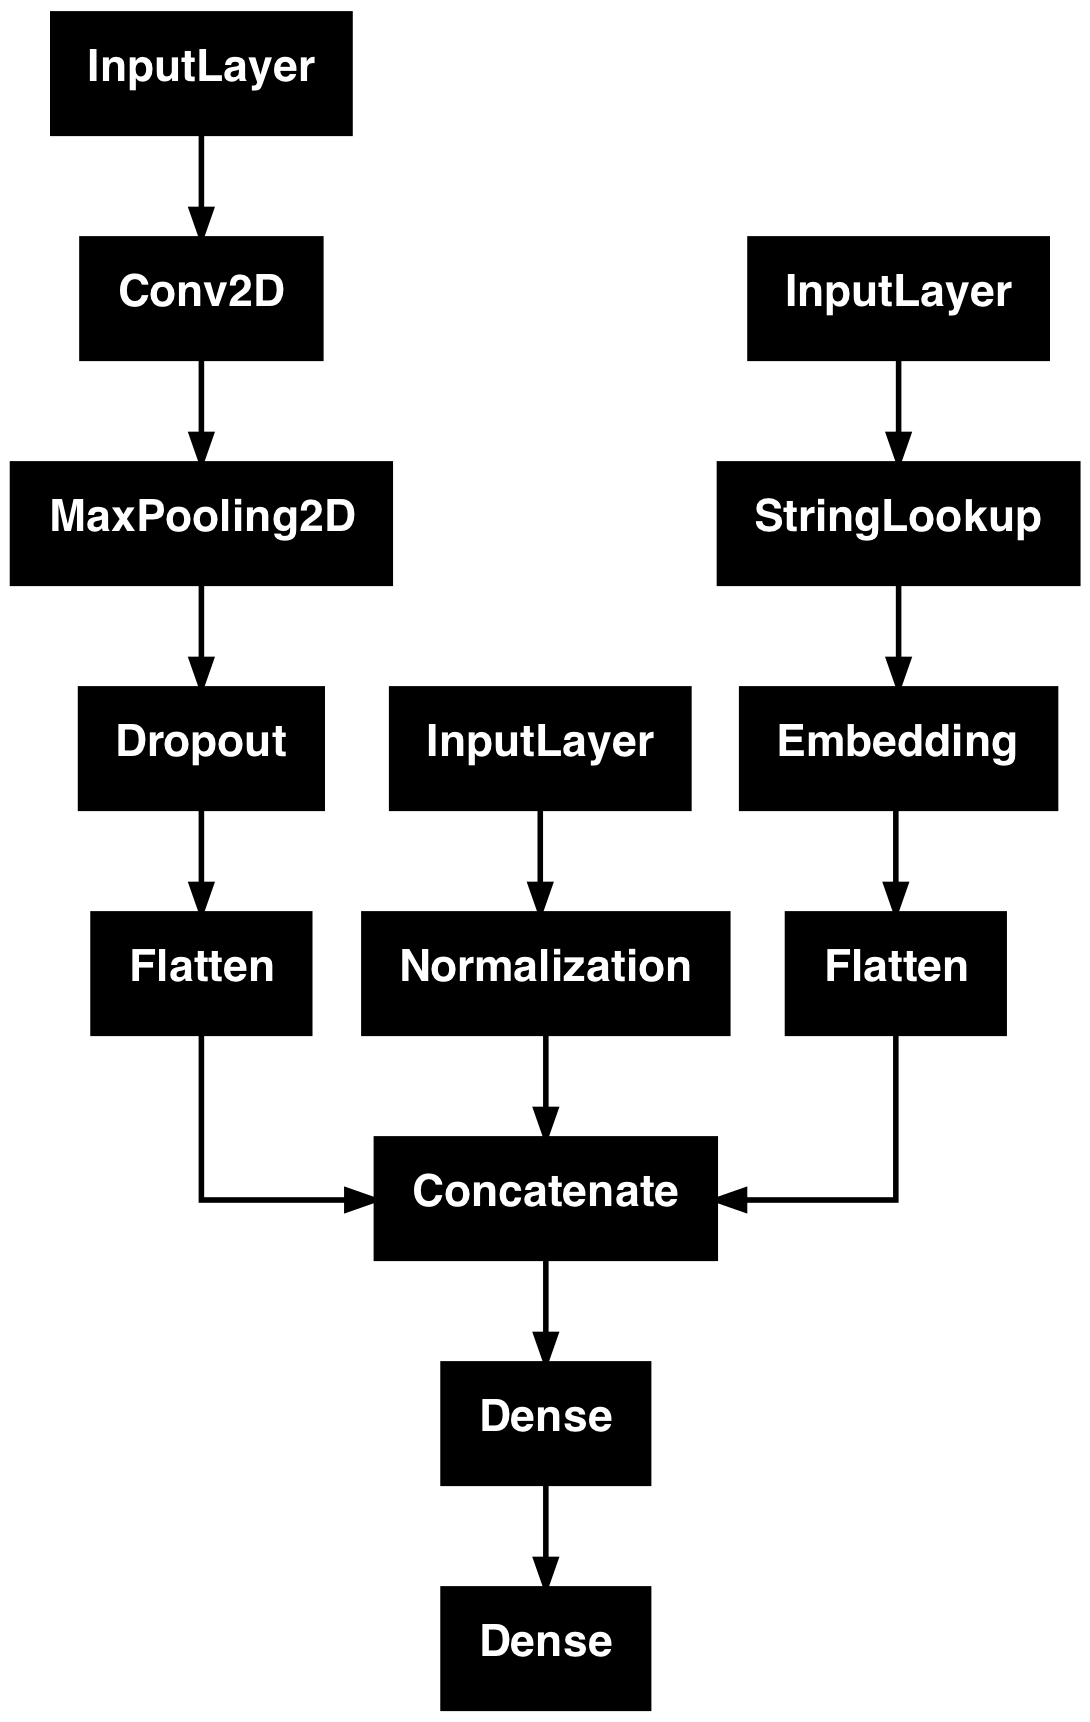

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 134s 471ms/step - accuracy: 0.2244 - loss: 56.0165 - val_accuracy: 0.0489 - val_loss: 3.2511
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 151s 535ms/step - accuracy: 0.3986 - loss: 2.0441 - val_accuracy: 0.0410 - val_loss: 3.4183
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 155s 549ms/step - accuracy: 0.4056 - loss: 1.9956 - val_accuracy: 0.1010 - val_loss: 3.0286
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 157s 558ms/step - accuracy: 0.4134 - loss: 1.9460 - val_accuracy: 0.1505 - val_loss: 2.9177
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 159s 564ms/step - accuracy: 0.4043 - loss: 1.9796 - val_accuracy: 0.0932 - val_loss: 3.1228
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 160s 568ms/step - accuracy: 0.4141 - loss: 1.9349 - val_accuracy: 0.0632 - val_loss: 3.1462
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 168s 597ms/step - accuracy: 0.4174 - loss: 1.9195 - val_accuracy: 0.0971 - val_loss: 3.1257
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 163s 579ms/step - accuracy: 0.4172 

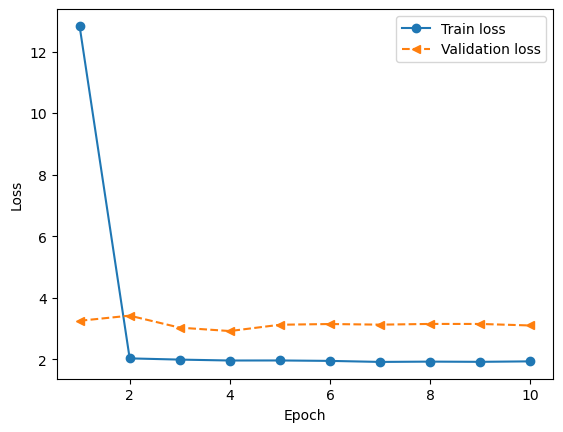

Training Accuracy: 0.41780325770378113
Validation Accuracy: 0.1179153099656105


In [19]:
model_4 = build_multimodal_CNN()
display(tf.keras.utils.plot_model(model_4))

# Ensure habitat input is passed as a string tensor directly
train_habitat_strings = tf.convert_to_tensor(habitat_str_train, dtype=tf.string)
val_habitat_strings = tf.convert_to_tensor(habitat_str_val, dtype=tf.string)

history = model_4.fit(
  x={
      'image': train_images_shuffled,
      'elevation': elevation_int_train.reshape(-1, 1),
      'habitat': train_habitat_strings,
    },
  y=train_labels_class_shuffled,
  epochs=10,
  batch_size=64,
  validation_data=(
      {
        'image': val_images_shuffled,
        'elevation': elevation_int_val.reshape(-1, 1),
        'habitat': val_habitat_strings,
      },
      val_labels_class_shuffled),
  verbose=1)


# plot loss curves
### YOUR CODE HERE ###
history_epochs = history.history
x_arr = np.arange(len(history_epochs['loss'])) + 1 
plt.plot(x_arr, history_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, history_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', history_epochs['accuracy'][-1])
print('Validation Accuracy:', history_epochs['val_accuracy'][-1])

In [20]:
# getting the test accuracy
test_loss, test_accuracy = model_4.evaluate(
    x={
        'image': test_images_shuffled,
        'elevation': elevation_int_test.reshape(-1, 1),
        'habitat': tf.convert_to_tensor(habitat_str_test, dtype=tf.string), 
    },
    y=test_labels_class_shuffled,
    verbose=1
)
print(f"Test accuracy: {test_accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.0732 - loss: 3.5004
Test accuracy: 0.0716


In [21]:
print(f"train_images_shuffled shape: {train_images_shuffled.shape}")
print(f"elevation_int_train shape: {elevation_int_train.shape}")
print(f"habitat_str_train shape: {habitat_str_train.shape}")
print(f"train_labels_class_shuffled shape: {train_labels_class_shuffled.shape}")

train_images_shuffled shape: (17963, 224, 224, 3)
elevation_int_train shape: (17963,)
habitat_str_train shape: (17963,)
train_labels_class_shuffled shape: (17963,)


In [22]:
print(habitat_str_train[:10])  # Inspect the first 10 values
print(type(habitat_str_train))  # Check the type of the data
print(habitat_str_train.dtype)  # Check the dtype of the NumPy array

['Forest bog' 'garden' 'Thorny scrubland' 'Thorny scrubland'
 'Deciduous woodland' 'Bog woodland' 'Deciduous woodland'
 'natural grassland' 'garden' 'masonry']
<class 'numpy.ndarray'>
<U52
